In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]


In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import payout_from_bid
from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier


In [4]:
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, metrics, cv


In [5]:
from catboost.utils import get_gpu_device_count

use_gpu = False
if get_gpu_device_count():
    use_gpu = True


In [6]:
# Global notebook params (speed processing of stuff we want only once)
use_years_as_weights = True

do_manual_svc = True
do_manual_bagging = True
do_sklearn_grid_tree = True
do_xgboost = True
do_catboost = True


In [7]:
basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data', 'derived', 'cleaned_matches.csv')
defense = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'DEFENSE_stats.csv')
snaps = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'SNAP_COUNTS_stats.csv')

cleaned_matches = pd.read_csv(data)
# defense_stats = pd.read_csv(defense, index_col=[0,1,2])
# snaps_stats = pd.read_csv(snaps, index_col=[0,1,2])

In [8]:
teams_and_codes = cleaned_matches.groupby(['Team', 'Team Code']).count().index.to_series().reset_index(level=1).drop(columns=[0])
opponents_and_codes = cleaned_matches.groupby(['Opponent', 'Opponent Code']).count().index.to_series().reset_index(level=1).drop(columns=[0])
teams_and_codes.columns = ['Code']
opponents_and_codes.columns = ['Code']

In [9]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date', inplace=True, ascending=True)
cleaned_matches.drop(cleaned_matches.index[cleaned_matches.Date.dt.year >= 2008], inplace=True)
cleaned_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24884 entries, 0 to 24866
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             24884 non-null  object        
 1   Date            24884 non-null  datetime64[ns]
 2   Home/Away       24884 non-null  object        
 3   Opponent        24884 non-null  object        
 4   Score           24884 non-null  object        
 5   W/L/T           24884 non-null  object        
 6   Overtime        686 non-null    object        
 7   Location        24884 non-null  object        
 8   Venue           24883 non-null  object        
 9   Attendance      24568 non-null  float64       
 10  Notes           947 non-null    object        
 11  Opponent Code   24884 non-null  object        
 12  Team            24884 non-null  object        
 13  Team Code       24884 non-null  object        
 14  Team Score      24711 non-null  float64       
 15  Op

In [10]:
cleaned_matches['Pct Team Score'] = cleaned_matches['Team Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])
cleaned_matches['Pct Opponent Score'] = cleaned_matches['Opponent Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])

oldest_match_year = np.min(cleaned_matches['Date'].dt.year)

cleaned_matches['Weight'] = (cleaned_matches['Date'].dt.year - oldest_match_year
                             ) if use_years_as_weights else np.ones(cleaned_matches['Date'].shape)


## Train to classify based on the last-n-games a team played

In [11]:
x_cols = [
    'Team Code',
    'Opponent Code',
    'Home/Away'
]
lookup_x_cols = [
    'Team Score',
    'Opponent Score',
    'Score Diff',
    'Pct Team Score',
    'Pct Opponent Score',
    'Home/Away'
]
key_x_cols = [
    'Team Code',
    'Opponent Code'
]
weight_cols = [
    'Weight'
]
y_cols = [
    'Class'
]
date_cols_by_key = [['Team Code_p_Date',
                     'Team Code_pp_Date',
                     'Team Code_ppp_Date',
                     'Team Code_pppp_Date',
                     'Team Code_ppppp_Date',
                     ],
                    ['Opponent Code_p_Date',
                     'Opponent Code_pp_Date',
                     'Opponent Code_ppp_Date',
                     'Opponent Code_pppp_Date',
                     'Opponent Code_ppppp_Date',
                     ]]

filter_col = 'Date'

played_matches = cleaned_matches.dropna(
    axis=0, how='any', subset=x_cols + y_cols + lookup_x_cols).copy()

played_matches['Class'].where(
    played_matches['Class'] > 0, other=0, inplace=True)


played_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24579 entries, 0 to 24866
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Day                 24579 non-null  object        
 1   Date                24579 non-null  datetime64[ns]
 2   Home/Away           24579 non-null  object        
 3   Opponent            24579 non-null  object        
 4   Score               24579 non-null  object        
 5   W/L/T               24579 non-null  object        
 6   Overtime            686 non-null    object        
 7   Location            24579 non-null  object        
 8   Venue               24578 non-null  object        
 9   Attendance          24281 non-null  float64       
 10  Notes               929 non-null    object        
 11  Opponent Code       24579 non-null  object        
 12  Team                24579 non-null  object        
 13  Team Code           24579 non-null  object    

In [12]:
def dataset_transformer():
    return ColumnTransformer([('scaler', StandardScaler(), numeric_columns), ('one-hot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])


In [146]:
last_n_matches, new_columns = form_last_n_games(
    played_matches, 5, lookup_x_cols, key_x_cols, filter_col)


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


.................................................
 Done


In [147]:
for date_cols in date_cols_by_key:
    last_n_matches = last_n_matches.drop(
        last_n_matches.index[last_n_matches[[filter_col] + date_cols].diff(axis=1)[date_cols[0]].dt.days == 0])
    last_n_matches[date_cols] = last_n_matches[[filter_col] + date_cols].diff(axis=1)[date_cols]

last_n_matches.drop(columns=filter_col, inplace=True)
last_n_matches.head()


,Day,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,...,Team Code_p_Date,Opponent Code_p_Date,Team Code_pp_Date,Opponent Code_pp_Date,Team Code_ppp_Date,Opponent Code_ppp_Date,Team Code_pppp_Date,Opponent Code_pppp_Date,Team Code_ppppp_Date,Opponent Code_ppppp_Date
61,Thu,A,Akron Pros,0-7,L,NaN,"Akron, OH",League Park,6500.0,NaN,...,-4 days,-4 days,-7 days,-7 days,-7 days,-14 days,-7 days,-7 days,-7 days,-14 days
60,Thu,H,Canton Bulldogs,7-0,W,NaN,"Akron, OH",League Park,6500.0,NaN,...,-4 days,-4 days,-7 days,-7 days,-14 days,-7 days,-7 days,-7 days,-14 days,-7 days
70,Sun,H,Akron Pros,0-14,L,NaN,"Dayton, OH",Triangle Park,5000.0,NaN,...,-3 days,-3 days,-4 days,-4 days,-7 days,-7 days,-21 days,-14 days,-7 days,-7 days
66,Sun,A,Dayton Triangles,14-0,W,NaN,"Dayton, OH",Triangle Park,5000.0,NaN,...,-3 days,-3 days,-4 days,-4 days,-7 days,-7 days,-14 days,-21 days,-7 days,-7 days
81,Sun,A,Akron Pros,0-14,L,NaN,"Akron, OH",League Park,1700.0,NaN,...,-315 days,-301 days,-14 days,-3 days,-7 days,-4 days,-14 days,-7 days,-7 days,-14 days


In [148]:
for date_cols in date_cols_by_key:
  for date_col in date_cols:
    last_n_matches[date_col] = last_n_matches[date_col].dt.days

In [149]:
X = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y = last_n_matches[y_cols]
weights = played_matches[weight_cols].loc[last_n_matches.index,:]

numeric_columns = X.columns[X.columns.str.contains('Score')]
categorical_columns = X.columns[~X.columns.str.contains('Score')]
categorical_columns_indices = np.where(~X.columns.str.contains('Score'))[0]

print(categorical_columns)
print(categorical_columns_indices)
print(numeric_columns)
print(weights)


Index(['Team Code', 'Opponent Code', 'Home/Away', 'Team Code_p_Home/Away',
       'Opponent Code_p_Home/Away', 'Team Code_pp_Home/Away',
       'Opponent Code_pp_Home/Away', 'Team Code_ppp_Home/Away',
       'Opponent Code_ppp_Home/Away', 'Team Code_pppp_Home/Away',
       'Opponent Code_pppp_Home/Away', 'Team Code_ppppp_Home/Away',
       'Opponent Code_ppppp_Home/Away', 'Team Code_p_Date',
       'Opponent Code_p_Date', 'Team Code_pp_Date', 'Opponent Code_pp_Date',
       'Team Code_ppp_Date', 'Opponent Code_ppp_Date', 'Team Code_pppp_Date',
       'Opponent Code_pppp_Date', 'Team Code_ppppp_Date',
       'Opponent Code_ppppp_Date'],
      dtype='object')
[ 0  1  2 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',

In [150]:
X.head()


,Team Code,Opponent Code,Home/Away,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,...,Team Code_p_Date,Opponent Code_p_Date,Team Code_pp_Date,Opponent Code_pp_Date,Team Code_ppp_Date,Opponent Code_ppp_Date,Team Code_pppp_Date,Opponent Code_pppp_Date,Team Code_ppppp_Date,Opponent Code_ppppp_Date
61,can,akr,A,3.0,0.0,21.0,7.0,18.0,0.0,0.0,...,-4,-4,-7,-7,-7,-14,-7,-7,-7,-14
60,akr,can,H,13.0,0.0,7.0,0.0,10.0,0.0,7.0,...,-4,-4,-7,-7,-14,-7,-7,-7,-14,-7
70,day,akr,H,28.0,0.0,0.0,0.0,21.0,7.0,20.0,...,-3,-3,-4,-4,-7,-7,-21,-14,-7,-7
66,akr,day,A,7.0,0.0,13.0,13.0,7.0,0.0,10.0,...,-3,-3,-4,-4,-7,-7,-14,-21,-7,-7
81,col,akr,A,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-315,-301,-14,-3,-7,-4,-14,-7,-7,-14


In [59]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23992 entries, 61 to 24866
Data columns (total 73 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Team Code                               23992 non-null  object 
 1   Opponent Code                           23992 non-null  object 
 2   Home/Away                               23992 non-null  object 
 3   Team Code_p_Team Score                  23992 non-null  float64
 4   Opponent Code_p_Team Score              23992 non-null  float64
 5   Team Code_pp_Team Score                 23992 non-null  float64
 6   Opponent Code_pp_Team Score             23992 non-null  float64
 7   Team Code_ppp_Team Score                23992 non-null  float64
 8   Opponent Code_ppp_Team Score            23992 non-null  float64
 9   Team Code_pppp_Team Score               23992 non-null  float64
 10  Opponent Code_pppp_Team Score           23992 non-null  f

In [60]:
# X.corr()


In [61]:
y.head()


,Class
61,0
60,1
70,0
66,1
81,0


In [62]:
last_1_pct = len(X) - len(X)//20
X_chrono_test = X.iloc[last_1_pct:]
y_chrono_test = y.iloc[last_1_pct:]
weight_chrono_test = weights.loc[X_chrono_test.index,:]

X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
    X, y, test_pct=0.2, val_pct=0.2, random_state=0
)

weight_train = weights.loc[X_train.index,:]
weight_val = weights.loc[X_val.index,:]
weight_test = weights.loc[X_test.index,:]

print(X.shape, y.shape, weights.shape)
print(X_train.shape, y_train.shape, weight_train.shape)
print(X_val.shape, y_val.shape, weight_val.shape)
print(X_test.shape, y_test.shape, weight_test.shape)
print(X_chrono_test.shape, y_chrono_test.shape, weight_chrono_test.shape)


(23992, 73) (23992, 1) (23992, 1)
(14394, 73) (14394, 1) (14394, 1)
(4799, 73) (4799, 1) (4799, 1)
(4799, 73) (4799, 1) (4799, 1)
(1199, 73) (1199, 1) (1199, 1)


In [63]:
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])
weight_cv = pd.concat([weight_train, weight_val])

Evaluating linear kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


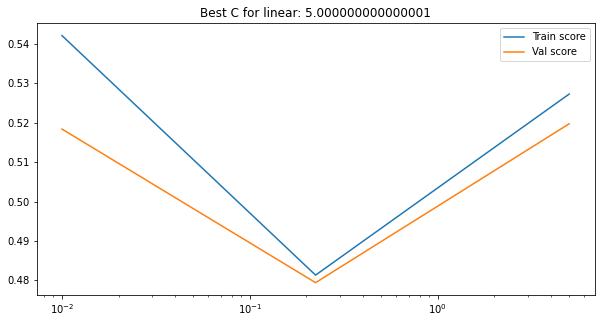

Evaluating poly kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating poly kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating poly kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


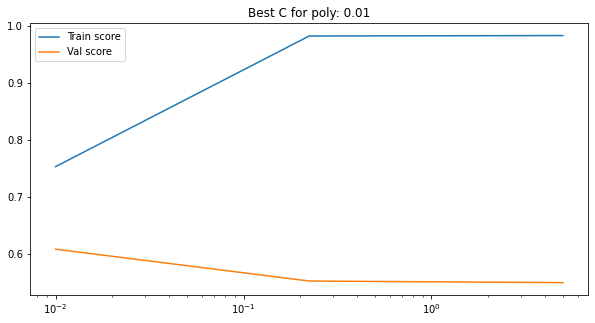

Evaluating rbf kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating rbf kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating rbf kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


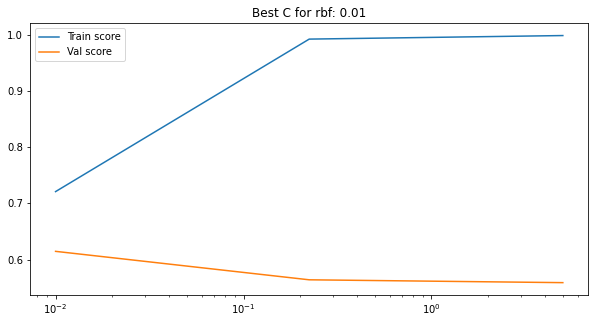

Evaluating sigmoid kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating sigmoid kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating sigmoid kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


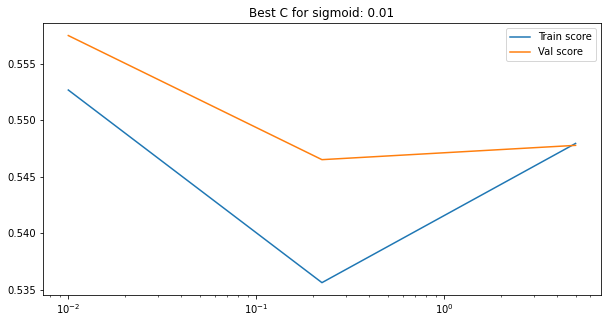

In [22]:
def manual_grid_search_svc(do=True):
    if not do:
        return None
    best_model = None
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        train_scores = []
        val_scores = []
        val_space = np.geomspace(start=0.01, stop=5, num=3)
        for C in val_space:
            print(f"Evaluating {kernel} kernel for C={C}")
            model = make_pipeline(dataset_transformer(), svm.SVC(
                C=C, max_iter=10_000, kernel=kernel))

            model.fit(X_train, y_train.values.ravel(), svc__sample_weight=weight_train.values.ravel())
            train_scores.append(model.score(X_train, y_train.values.ravel(), weight_train.values.ravel()))
            val_scores.append(model.score(X_val, y_val.values.ravel(), weight_val.values.ravel()))

            if best_model is None or val_scores[-1] == np.max(val_scores):
                best_model = model

        plt.title(f'Best C for {kernel}: {val_space[np.argmax(val_scores)]}')
        plt.plot(val_space, train_scores, label='Train score')
        plt.plot(val_space, val_scores, label='Val score')
        # plt.ylim(0, 1.1)
        plt.xscale('log')
        plt.legend()
        plt.show()
    return best_model


best_model = manual_grid_search_svc(do_manual_svc)


In [23]:
if best_model is not None:
    y_pred = best_model.predict(X_test)
    precision, recall, fbeta_score, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary')
    print(precision, recall, fbeta_score)


0.5513816925734024 0.539046010975095 0.5451440768409819


In [24]:
def manual_grid_bagging(do=True):
    if not do:
        return [], [], 0, 0
    best_config = []
    best_score = 0
    best_fit_config = []
    best_fit_score = 0
    for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=10), DecisionTreeClassifier(max_leaf_nodes=20)]:
        for nestimators in [10, 31, 62, 93, 124]:
            for nsamples in [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6]:
                clf = make_pipeline(dataset_transformer(), BaggingClassifier(
                    base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples))
                clf.fit(X_train, y_train.values.ravel(
                ), baggingclassifier__sample_weight=weight_train.values.ravel())

                score = clf.score(X_val, y_val.values.ravel(),
                                  weight_val.values.ravel())
                if(score > best_score):
                    best_config = [estimator, nestimators, nsamples]
                    best_score = score

                score = clf.score(X_train, y_train.values.ravel(),
                                  weight_train.values.ravel())
                if(score > best_fit_score):
                    best_fit_config = [estimator, nestimators, nsamples]
                    best_fit_score = score

                print(end='.')
            print(end='*')
        print(end='#')
    return best_config, best_fit_config, best_score, best_fit_score


best_config, best_fit_config, best_score, best_fit_score = manual_grid_bagging(
    do_manual_bagging)


.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#

In [25]:
print(f"Best validation: {best_score}, {best_config}")
print(f"Best training: {best_fit_score}, {best_fit_config}")


Best validation: 0.6242475005791884, [DecisionTreeClassifier(max_leaf_nodes=10), 93, 0.05]
Best training: 0.9998480499544748, [DecisionTreeClassifier(), 500, 0.6]


In [26]:
if do_manual_bagging:
    bagging_model = make_pipeline(dataset_transformer(), BaggingClassifier(
        base_estimator=best_config[0], n_estimators=best_config[1], max_samples=best_config[2]))
    bagging_model.fit(X_train, y_train.values.ravel(
    ), baggingclassifier__sample_weight=weight_train.values.ravel())


In [27]:
model = {
    'model': BaggingClassifier,
    'kwargs': {'base_estimator': DecisionTreeClassifier()},
    'cross_vals': 3,
    'param_grid': {
        'bagging_clf__base_estimator__max_leaf_nodes': np.linspace(2, 100, num=4, dtype=int),
        'bagging_clf__max_samples': np.linspace(0.01, 0.8, 4),
        'bagging_clf__n_estimators': np.geomspace(10, 100, num=3, dtype=int)
    }
}

pipe = Pipeline([('column_transformer', dataset_transformer()),
                 ('bagging_clf', model['model'](**model['kwargs']))])

print(model)

grid_search_bag_tree = model_selection.GridSearchCV(
    pipe, param_grid=model['param_grid'], cv=model['cross_vals'], n_jobs=5, refit=True, verbose=3)


{'model': <class 'sklearn.ensemble._bagging.BaggingClassifier'>, 'kwargs': {'base_estimator': DecisionTreeClassifier()}, 'cross_vals': 3, 'param_grid': {'bagging_clf__base_estimator__max_leaf_nodes': array([  2,  34,  67, 100]), 'bagging_clf__max_samples': array([0.01      , 0.27333333, 0.53666667, 0.8       ]), 'bagging_clf__n_estimators': array([ 10,  31, 100])}}


In [28]:
if do_sklearn_grid_tree:
    grid_search_bag_tree.fit(X_cv, y_cv.values.ravel(), **{
                             'bagging_clf__sample_weight': weight_cv.values.ravel()})
                             


Fitting 3 folds for each of 48 candidates, totalling 144 fits


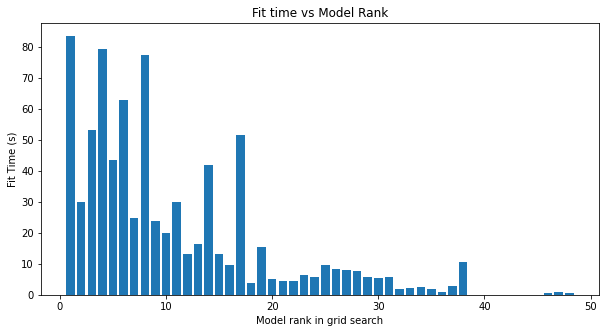

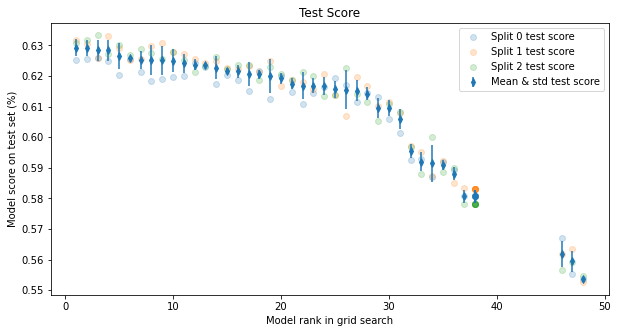

In [30]:
if do_sklearn_grid_tree:
    # print(grid_search_bag_tree.cv_results_.keys())

    x = grid_search_bag_tree.cv_results_['rank_test_score']
    plt.bar(x, grid_search_bag_tree.cv_results_['mean_fit_time'])
    plt.title('Fit time vs Model Rank')
    plt.xlabel('Model rank in grid search')
    plt.ylabel('Fit Time (s)')
    plt.show()

    plt.errorbar(x, grid_search_bag_tree.cv_results_['mean_test_score'], grid_search_bag_tree.cv_results_['std_test_score'], fmt='d', markersize=5, label='Mean & std test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split0_test_score'], alpha=0.2, label='Split 0 test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split1_test_score'], alpha=0.2, label='Split 1 test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split2_test_score'], alpha=0.2, label='Split 2 test score')
    plt.title('Test Score')
    plt.xlabel('Model rank in grid search')
    plt.ylabel('Model score on test set (%)')
    plt.legend()
    plt.show()

In [31]:
if do_sklearn_grid_tree:
  print(
      f"Test score={grid_search_bag_tree.best_estimator_.score(X_test,y_test.values.ravel(), weight_test.values.ravel())}")
  print(
      f"Chronological test score={grid_search_bag_tree.best_estimator_.score(X_chrono_test, y_chrono_test.values.ravel(), weight_chrono_test.values.ravel())}")


Test score=0.6205956233046308
Chronological test score=0.6982566281933645


Scores for last 5% of games=0.6947456213511259


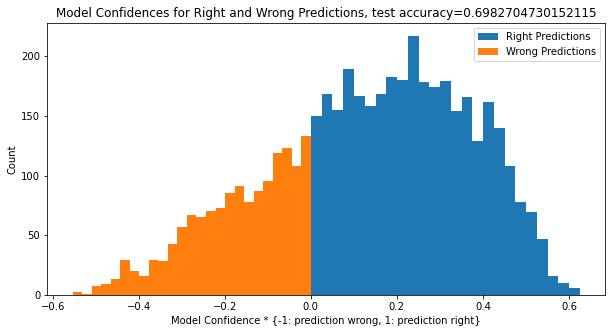

In [179]:
if do_sklearn_grid_tree:
    confidences = grid_search_bag_tree.best_estimator_.predict_proba(X_test)
    confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
    wrong_preds = confidences[confidences < 0]
    right_preds = confidences[confidences > 0]
    print(f"Scores for last 5% of games={grid_search_bag_tree.best_estimator_.score(X_chrono_test, y_chrono_test)}")
    
    plt.title(f'Model Confidences for Right and Wrong Predictions, test accuracy={grid_search_bag_tree.best_estimator_.score(X_test, y_test.values.ravel())}')
    plt.hist(right_preds, bins=25, label='Right Predictions')
    plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
    plt.legend()
    plt.xlabel('Model Confidence * {-1: prediction wrong, 1: prediction right}')
    plt.ylabel('Count')
    plt.show()


In [412]:
clf = make_pipeline(dataset_transformer(), DecisionTreeClassifier())
clf.fit(X_train, y_train.values.ravel(), decisiontreeclassifier__sample_weight=weight_train.values.ravel())
clf.score(X_val, y_val.values.ravel(), weight_val.values.ravel())


0.5487143750558384

Scores for last 5% of games=0.8298582151793161


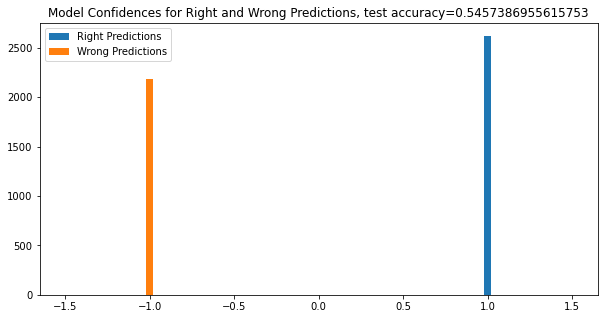

In [413]:
confidences = clf.predict_proba(X_test)
confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
wrong_preds = confidences[confidences < 0]
right_preds = confidences[confidences > 0]
print(f"Scores for last 5% of games={clf.score(X_chrono_test, y_chrono_test.values.ravel())}")
plt.title(f'Model Confidences for Right and Wrong Predictions, test accuracy={clf.score(X_test, y_test.values.ravel())}')
plt.hist(right_preds, bins=25, label='Right Predictions')
plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
plt.legend()
plt.show()


In [36]:
if do_manual_svc:
    Cs = np.geomspace(0.01, 15, num=50)
    scores = []
    for c in Cs:
        model = make_pipeline(dataset_transformer(), svm.LinearSVC(
            dual=False, C=c, max_iter=100_000))
        scores.append(cross_val_score(
            model, X_cv, y_cv.values.ravel(), cv=3, fit_params={'linearsvc__sample_weight': weight_cv.values.ravel()}, n_jobs=-1))
        print(end='.')


..................................................

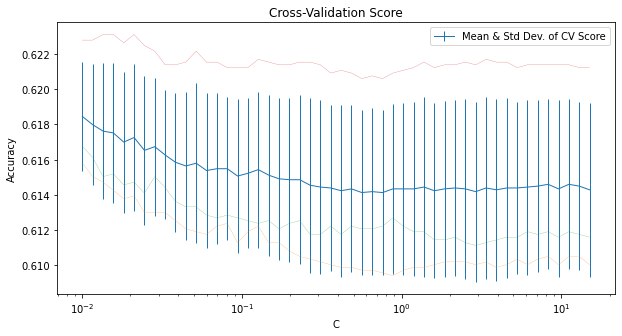

In [37]:
if do_manual_svc:
    x = Cs
    plt.errorbar(x, np.mean(scores, axis=1), np.std(scores, axis=1),
                 label='Mean & Std Dev. of CV Score', linewidth=1)
    plt.plot(x, np.sort(scores, axis=1), linewidth=0.2)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Score')
    plt.show()


In [38]:
if do_manual_svc:
    print('Maximum mean:', np.max(np.mean(scores, axis=1)))
    print('Corresponding std deviation:', np.std(
        scores, axis=1)[np.argmax(np.mean(scores, axis=1))])
    print('C:', Cs[np.argmax(np.mean(scores, axis=1))])


Maximum mean: 0.6184548708937021
Corresponding std deviation: 0.003090571621182334
C: 0.01


In [39]:
if do_manual_svc:
    print('Minimum std deviation:', np.min(np.std(scores, axis=1)))
    print('Corresponding mean:', np.mean(scores, axis=1)
          [np.argmin(np.std(scores, axis=1))])
    print('C:', Cs[np.argmin(np.std(scores, axis=1))])


Minimum std deviation: 0.003090571621182334
Corresponding mean: 0.6184548708937021
C: 0.01


In [40]:
if do_manual_svc:
    best_mean_cs = np.flip(np.argsort(np.mean(scores, axis=1)))
    best_std_cs = np.argsort(np.std(scores, axis=1))


In [41]:
if do_manual_svc:
    # Do some random perturbation of the Cs
    scores = []

    Cs_to_examine = np.unique(np.concatenate(
        (Cs[best_mean_cs[:5]], Cs[best_std_cs[:5]])))
    Cs_to_examine = np.unique(np.concatenate([Cs_to_examine, np.abs(
        Cs_to_examine + np.random.normal(scale=0.2, size=len(Cs_to_examine)))]))

    for c in Cs_to_examine:
        model = make_pipeline(dataset_transformer(), svm.LinearSVC(
            dual=False, C=c, max_iter=100_000))

        scores.append(cross_val_score(
            model, X_cv, y_cv.values.ravel(), cv=5, n_jobs=-1, fit_params={'linearsvc__sample_weight': weight_cv.values.ravel()}))

        print(end='.')


..............

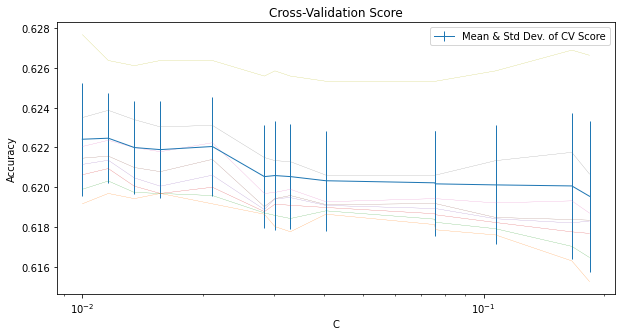

In [42]:
if do_manual_svc:
    x = Cs_to_examine
    quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
    plt.errorbar(x, np.mean(scores, axis=1), np.std(scores, axis=1),
                 label='Mean & Std Dev. of CV Score', linewidth=1)
    plt.plot(x, np.quantile(scores, quantiles, axis=1).T, linewidth=0.2)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Score')
    plt.show()


In [43]:
if do_manual_svc:
    best_mean_idx = np.argmax(np.mean(scores, axis=1))

    print(
        f'Best C={Cs_to_examine[best_mean_idx]} with mean={np.mean(scores,axis=1)[best_mean_idx]}, std={np.std(scores,axis=1)[best_mean_idx]}')


Best C=0.01160962492108241 with mean=0.6224667678651443, std=0.0022564612081825202


In [44]:
if do_manual_svc:
    # Train the best model.

    linear_model = make_pipeline(dataset_transformer(),
                          svm.LinearSVC(dual=False, C=Cs_to_examine[best_mean_idx], max_iter=100_000))
    linear_model.fit(X_cv, y_cv.values.ravel(),
              linearsvc__sample_weight=weight_cv.values.ravel())
    linear_model.score(X_test, y_test.values.ravel())


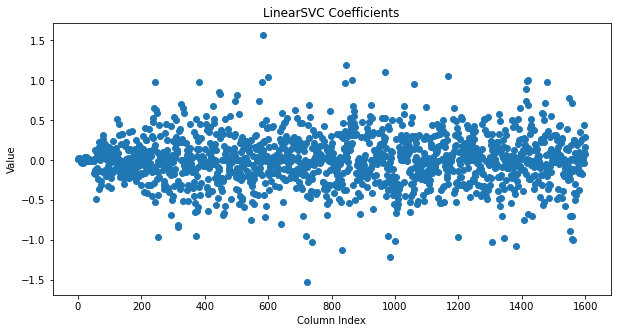

In [409]:
if do_manual_svc:
    coefs = linear_model[1].coef_[0]
    plt.scatter(x=np.arange(len(coefs)), y=coefs)
    plt.title('LinearSVC Coefficients')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.show()


In [50]:
if do_manual_svc:
    linear_model.fit(X_train, y_train.values.ravel(),
              linearsvc__sample_weight=weight_train.values.ravel())
    confidences = linear_model.decision_function(X)
    print(f"Scores for last games={linear_model.score(X_chrono_test, y_chrono_test.values.ravel(), weight_chrono_test.values.ravel())}")
    print(f"Scores for test games={linear_model.score(X_test, y_test.values.ravel(), weight_test.values.ravel())}")


Scores for last games=0.6137441444922007
Scores for test games=0.6294572310073853


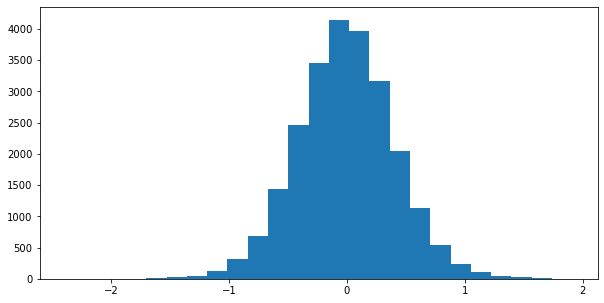

In [51]:
if do_manual_svc:
    plt.hist(confidences, bins=25)
    plt.show()


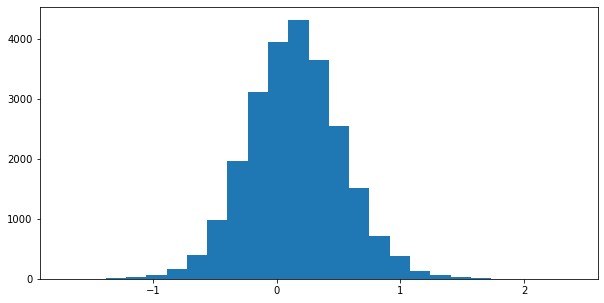

In [52]:
if do_manual_svc:
    plt.hist(confidences * (2 * y.to_numpy().ravel() - 1), bins=25)
    plt.show()


In [53]:
if do_manual_svc:
    np.min(confidences * (2 * y.to_numpy().ravel() - 1))


In [64]:
if do_catboost:
    catboost_model = CatBoostClassifier(
        custom_loss=[metrics.Accuracy()],
        random_seed=0xdeadbeef,
        logging_level='Silent',
        task_type='GPU' if use_gpu else 'CPU'
    )

    catboost_model.fit(
        X_cv, y_cv,sample_weight=weight_cv,
        cat_features=categorical_columns_indices,
        eval_set=(X_test, y_test),
        early_stopping_rounds=100,
        plot=True
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [65]:
if do_catboost:
    data_pool = Pool(X_cv, y_cv, cat_features=categorical_columns_indices, weight=weight_cv)
    cv_params = catboost_model.get_params()
    cv_params.update({
        'loss_function': metrics.Logloss()
    })
    cv_data = cv(
        data_pool,
        cv_params,
        plot=True,
        early_stopping_rounds=100
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
if do_catboost:
    print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
        np.max(cv_data['test-Accuracy:use_weights=true-mean']),
        cv_data['test-Accuracy:use_weights=true-std'][np.argmax(cv_data['test-Accuracy:use_weights=true-mean'])],
        np.argmax(cv_data['test-Accuracy:use_weights=true-mean'])
    ))
    print()
    
    feature_importances = catboost_model.get_feature_importance(data_pool)
    feature_names = X_train.columns
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
        print('{}: {}'.format(name, score))


Best validation accuracy score: 0.62±0.00 on step 541

Home/Away: 7.378931760329934
Opponent Code_ppppp_Date: 5.14237204913273
Team Code_ppppp_Date: 5.117585359931498
Opponent Code_pp_Date: 5.0156430122929265
Team Code_pppp_Date: 4.732688263910093
Team Code_p_Date: 4.475481270487487
Opponent Code_pppp_Date: 4.421890872492681
Opponent Code_ppp_Date: 4.383049978468253
Team Code_pp_Date: 3.9967809260563185
Opponent Code: 3.910341103681711
Team Code: 3.427309728718649
Team Code_ppp_Date: 3.297774796573645
Opponent Code_p_Date: 3.2434017411789777
Opponent Code_pp_Score Diff: 3.1915670025780423
Team Code_p_Score Diff: 2.5600554090004195
Team Code_pp_Score Diff: 1.9116763135469672
Opponent Code_p_Pct Team Score: 1.7917120082571307
Team Code_p_Pct Team Score: 1.6588338221852819
Opponent Code_ppppp_Score Diff: 1.6359860118357656
Team Code_pppp_Score Diff: 1.6008050026520524
Opponent Code_p_Pct Opponent Score: 1.533998674378494
Opponent Code_ppp_Score Diff: 1.3897716010036079
Team Code_ppp_Pct T

Scores for last 5% of games=0.5954962468723937


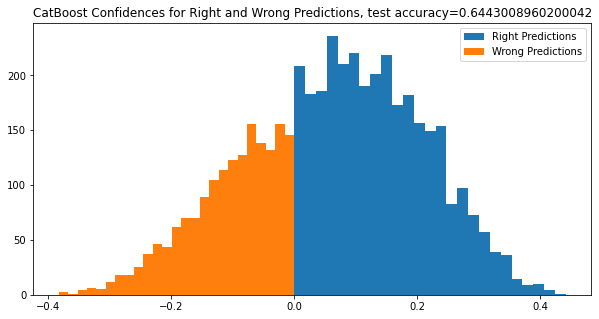

In [414]:
if do_catboost:
    confidences = catboost_model.predict_proba(X_test)
    confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
    wrong_preds = confidences[confidences < 0]
    right_preds = confidences[confidences > 0]
    print(f"Scores for last 5% of games={catboost_model.score(X_chrono_test, y_chrono_test)}")
    plt.title(f'CatBoost Confidences for Right and Wrong Predictions, test accuracy={catboost_model.score(X_test, y_test.values.ravel())}')
    plt.hist(right_preds, bins=25, label='Right Predictions')
    plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
    plt.legend()
    plt.show()


Train accuracy=0.8584900745063304
Scores for last 5% of games=0.8656686144781958


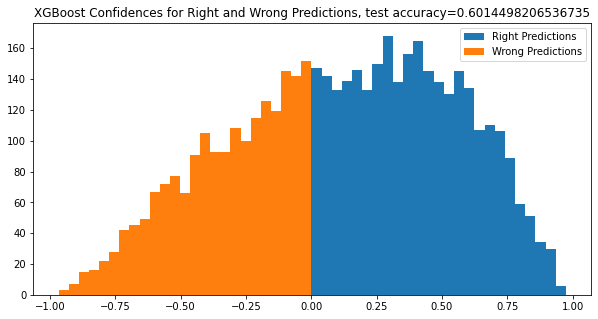

In [415]:
if do_xgboost:
  xgboost_model = make_pipeline(dataset_transformer(),xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss'))
  xgboost_model.fit(X_cv, y_cv.values.ravel(), xgbclassifier__sample_weight=weight_cv.values.ravel())
  print(f'Train accuracy={xgboost_model.score(X_cv, y_cv.values.ravel())}')
  
  confidences = xgboost_model.predict_proba(X_test)
  confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
  wrong_preds = confidences[confidences < 0]
  right_preds = confidences[confidences > 0]
  print(f"Scores for last 5% of games={xgboost_model.score(X_chrono_test, y_chrono_test.values.ravel(), weight_chrono_test.values.ravel())}")
  plt.title(f'XGBoost Confidences for Right and Wrong Predictions, test accuracy={xgboost_model.score(X_test, y_test.values.ravel(), weight_test.values.ravel())}')
  plt.hist(right_preds, bins=25, label='Right Predictions')
  plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
  plt.legend()
  plt.show()

In [69]:
odds_data = pd.read_csv(os.path.join(basedir, 'data', 'derived', 'odds_portal_clean.csv'))
odds_data = odds_data.loc[odds_data['Special Game'].str.contains('All Stars').isna(),:]

odds_data['Date'] = pd.to_datetime(odds_data['Date'])
odds_data['Home Score'] = pd.to_numeric(odds_data['Home Score'])
odds_data['Away Score'] = pd.to_numeric(odds_data['Away Score'].str.strip())

odds_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3414 entries, 0 to 4328
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Season        3414 non-null   object        
 1   Date          3414 non-null   datetime64[ns]
 2   Special Game  0 non-null      object        
 3   Time          3414 non-null   object        
 4   Home Team     3414 non-null   object        
 5   Away Team     3414 non-null   object        
 6   Home Score    3414 non-null   int64         
 7   Away Score    3414 non-null   int64         
 8   OT            3414 non-null   bool          
 9   Winner        3414 non-null   object        
 10  Home Odds     3414 non-null   object        
 11  Away Odds     3414 non-null   object        
 12  B's           3414 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(8)
memory usage: 350.1+ KB


In [70]:
team_to_code = pd.concat([teams_and_codes, opponents_and_codes])


In [71]:
odds_data['Home Code'] = team_to_code.loc[odds_data['Home Team'].str.strip().to_list(), 'Code'].reset_index(drop=True)
odds_data['Away Code'] = team_to_code.loc[odds_data['Away Team'].str.strip().to_list(), 'Code'].reset_index(drop=True)
odds_data.head()

,Season,Date,Special Game,Time,Home Team,Away Team,Home Score,Away Score,OT,Winner,Home Odds,Away Odds,B's,Home Code,Away Code
0,2021/22,2021-11-16,NaN,1:15,San Francisco 49ers,Los Angeles Rams,31,10,False,Home,158,-182,13,sf,larm
1,2021/22,2021-11-15,NaN,1:20,Las Vegas Raiders,Kansas City Chiefs,14,41,False,Away,129,-149,13,sf,larm
2,2021/22,2021-11-14,NaN,21:25,Denver Broncos,Philadelphia Eagles,13,30,False,Away,-106,-110,13,lv,kc
3,2021/22,2021-11-14,NaN,21:25,Green Bay Packers,Seattle Seahawks,17,0,False,Home,-172,149,13,den,kc
4,2021/22,2021-11-14,NaN,21:05,Arizona Cardinals,Carolina Panthers,10,34,False,Away,-323,265,13,den,phi


In [72]:
pertinent_cols = [
    'Date',
    'Home Score',
    'Away Score',
    'Home Odds',
    'Away Odds',
    'Home Code',
    'Away Code'
]

odds_as_teams = odds_data.loc[:, pertinent_cols]
odds_as_opponents = odds_data.loc[:, pertinent_cols]

odds_as_teams.columns = [col.replace('Home', 'Team').replace(
    'Away', 'Opponent') for col in pertinent_cols]
odds_as_opponents.columns = [col.replace('Home', 'Opponent').replace(
    'Away', 'Team') for col in pertinent_cols]

odds_as_teams['Home/Away'] = 'H'
odds_as_opponents['Home/Away'] = 'A'

odds_as_matches = pd.concat([odds_as_teams, odds_as_opponents]).sort_values(
    ['Date', 'Team Code','Opponent Code'], ascending=True)

odds_as_matches['Weight'] = (odds_as_matches['Date'].dt.year - oldest_match_year
                             ) if use_years_as_weights else np.ones(odds_as_matches['Date'].shape)

odds_as_matches = odds_as_matches.reset_index(drop=True)

odds_as_matches.head()


,Date,Team Score,Opponent Score,Team Odds,Opponent Odds,Team Code,Opponent Code,Home/Away,Weight
0,2008-10-05,6,44,258,-303,bal,gb,A,88
1,2008-10-05,10,17,-263,225,bal,min,A,88
2,2008-10-05,13,10,-127,112,chib,pit,A,88
3,2008-10-05,0,34,371,-455,chib,pit,A,88
4,2008-10-05,34,7,-185,163,chic,ten,A,88


In [73]:
score_sum = odds_as_matches['Team Score'] + odds_as_matches['Opponent Score']
odds_as_matches['Pct Team Score'] = odds_as_matches['Team Score'] / score_sum
odds_as_matches['Pct Opponent Score'] = odds_as_matches['Opponent Score'] / score_sum

odds_as_matches['Score Diff'] = odds_as_matches['Team Score'] - \
    odds_as_matches['Opponent Score']

odds_as_matches['Class'] = pd.to_numeric(
    odds_as_matches['Team Score'] > odds_as_matches['Opponent Score']) * 1

odds_as_matches.head()


,Date,Team Score,Opponent Score,Team Odds,Opponent Odds,Team Code,Opponent Code,Home/Away,Weight,Pct Team Score,Pct Opponent Score,Score Diff,Class
0,2008-10-05,6,44,258,-303,bal,gb,A,88,0.120000,0.880000,-38,0
1,2008-10-05,10,17,-263,225,bal,min,A,88,0.370370,0.629630,-7,0
2,2008-10-05,13,10,-127,112,chib,pit,A,88,0.565217,0.434783,3,1
3,2008-10-05,0,34,371,-455,chib,pit,A,88,0.000000,1.000000,-34,0
4,2008-10-05,34,7,-185,163,chic,ten,A,88,0.829268,0.170732,27,1


In [111]:
from collections import deque

def form_last_n_games(df: pd.DataFrame, n: int, cols_to_grab=['Class'], lookup_cols=['Team Code'], filter_col='Date'):
    """
    Requires that the input df is sorted such that old elements are at the top,
    e.g. `df = df.sort_values(by='Date', ascending=True)`
    """

    steps = np.linspace(0, len(df), num=50, dtype=int)
    step_idx = 0
    itercount = 0

    result = df.copy()

    cols_to_grab = cols_to_grab.copy() + [filter_col]
    new_columns = [lookup + '_' + ''.join(['p']*(prev+1)) + '_' +
                   col for col in cols_to_grab for prev in range(n) for lookup in lookup_cols]
    new_df = pd.DataFrame(columns=new_columns)

    lookup_dict = {}
    for index, row in df.iterrows():
        itercount += 1
        to_drop = False
        append_row = pd.Series(index=new_columns, name=index)
        for lookup in lookup_cols:
            lkup_key = lookup + row[lookup]
            last_n = lookup_dict.get(lkup_key, deque(maxlen=n))

            if len(last_n) < n:
                to_drop = True
            else:
                for prev in range(n):
                    for col in cols_to_grab:
                        append_row[lookup + '_' +
                                   ''.join(['p']*(prev+1)) + '_' + col] = last_n[prev][col]
                    # append_cols = [
                    #     lookup + '_' + ''.join(['p']*(prev+1)) + '_' + col for col in cols_to_grab for prev in range(n)]
                    # append_row[append_cols] = [elem for r in last_n for elem in r[cols_to_grab]]

            if len(last_n) != 0 and row[filter_col] == last_n[0][filter_col]:
                continue
            last_n.appendleft(row[cols_to_grab])
            lookup_dict[lkup_key] = last_n

        if to_drop:
            result.drop(index, inplace=True)
        else:
            new_df = new_df.append(append_row)

        if itercount > steps[step_idx]:
            step_idx += 1
            print(end='.')
    print('\n Done')
    return pd.concat([result, new_df], axis=1), new_columns

In [127]:

last_n_matches, new_columns = form_last_n_games(
    odds_as_matches, 5, lookup_x_cols, key_x_cols, filter_col)
    

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


.................................................
 Done


In [128]:
for date_cols in date_cols_by_key:
    last_n_matches = last_n_matches.drop(
        last_n_matches.index[last_n_matches[[filter_col] + date_cols].diff(axis=1)[date_cols[0]].dt.days == 0])
    last_n_matches[date_cols] = last_n_matches[[filter_col] + date_cols].diff(axis=1)[date_cols]
    for date_col in date_cols:
      last_n_matches[date_col] = last_n_matches[date_col].dt.days

last_n_matches.drop(columns=filter_col, inplace=True)
last_n_matches.head()


,Team Score,Opponent Score,Team Odds,Opponent Odds,Team Code,Opponent Code,Home/Away,Weight,Pct Team Score,Pct Opponent Score,...,Team Code_p_Date,Opponent Code_p_Date,Team Code_pp_Date,Opponent Code_pp_Date,Team Code_ppp_Date,Opponent Code_ppp_Date,Team Code_pppp_Date,Opponent Code_pppp_Date,Team Code_ppppp_Date,Opponent Code_ppppp_Date
202,48,28,-130,114,ari,bal,A,88,0.631579,0.368421,...,-2,-2,-5,-7,-21,-3,-7,-16,-5,-14
203,28,48,114,-130,bal,ari,H,88,0.368421,0.631579,...,-2,-2,-7,-5,-3,-21,-16,-7,-14,-5
244,20,13,164,-179,hou,jac,A,88,0.606061,0.393939,...,-7,-7,-13,-13,-1,-1,-14,-14,-7,-5
245,13,20,-179,164,jac,hou,H,88,0.393939,0.606061,...,-7,-7,-13,-13,-1,-1,-14,-14,-5,-7
260,14,34,197,-233,hou,jac,A,88,0.291667,0.708333,...,-1,-1,-7,-7,-13,-13,-1,-1,-14,-14


In [129]:
X_odds = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y_odds = last_n_matches[y_cols]

odds = last_n_matches.loc[:, ['Team Odds','Opponent Odds']]
odds['Team Odds'] = pd.to_numeric(odds['Team Odds'])
odds['Opponent Odds'] = pd.to_numeric(odds['Opponent Odds'])

odds_weights = odds_as_matches[weight_cols].loc[last_n_matches.index, :]

numeric_columns = X_odds.columns[X_odds.columns.str.contains('Score')]
categorical_columns = X_odds.columns[~X_odds.columns.str.contains('Score')]
categorical_columns_indices = np.where(~X_odds.columns.str.contains('Score'))[0]

print(categorical_columns)
print(categorical_columns_indices)
print(numeric_columns)
print(odds_weights)


Index(['Team Code', 'Opponent Code', 'Home/Away', 'Team Code_p_Home/Away',
       'Opponent Code_p_Home/Away', 'Team Code_pp_Home/Away',
       'Opponent Code_pp_Home/Away', 'Team Code_ppp_Home/Away',
       'Opponent Code_ppp_Home/Away', 'Team Code_pppp_Home/Away',
       'Opponent Code_pppp_Home/Away', 'Team Code_ppppp_Home/Away',
       'Opponent Code_ppppp_Home/Away', 'Team Code_p_Date',
       'Opponent Code_p_Date', 'Team Code_pp_Date', 'Opponent Code_pp_Date',
       'Team Code_ppp_Date', 'Opponent Code_ppp_Date', 'Team Code_pppp_Date',
       'Opponent Code_pppp_Date', 'Team Code_ppppp_Date',
       'Opponent Code_ppppp_Date'],
      dtype='object')
[ 0  1  2 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',

In [378]:
def preds_to_confidences(preds):
    return np.array(2*np.max(preds, axis=1)-1) * (2*np.argmax(preds, axis=1) - 1).ravel()


def implied_probability(odds: np.ndarray):
    def num_to_prob(num):
      if num < 0:
        return -num / (100 - num)
      return 100 / (100 + num)
    
    return np.vectorize(num_to_prob)(odds)


In [430]:
def straight_bet_strategy(preds, odds, actual):
    confidences = preds_to_confidences(preds)
    odds_of_bet = np.where(
        confidences >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    results = (confidences * (2*actual.values.ravel() - 1)) > 0

    bids = np.ones(results.shape)
    winnings = payout_from_bid(bids, odds_of_bet, results)

    return winnings, bids


def proportional_bet_strategy(preds, odds, actual):
    confidences = preds_to_confidences(preds)
    odds_of_bet = np.where(
        confidences >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    results = (confidences * (2*actual.values.ravel() - 1)) > 0

    # Make integrated bid over confidences equal to straight, even though the distribution is not uniform
    bids = np.abs(confidences) + 0.5
    # Fixed amount of money to play with
    bids = bids * (len(bids) / np.sum(bids))

    winnings = payout_from_bid(bids, odds_of_bet, results)

    return winnings, bids


def quadratic_proportional_bet_strategy(preds, odds, actual):
    confidences = preds_to_confidences(preds)
    odds_of_bet = np.where(
        confidences >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    results = (confidences * (2*actual.values.ravel() - 1)) > 0

    # Make integrated bid over confidences equal to straight, even though the distribution is not uniform
    bids = np.square(np.abs(confidences)) + 2/3
    # Fixed amount of money to play with
    bids = bids * (len(bids) / np.sum(bids))

    winnings = payout_from_bid(bids, odds_of_bet, results)

    return winnings, bids


def risky_bet_strategy(preds, odds, actual):
    confidences = preds_to_confidences(preds)
    odds_of_bet = np.where(
        confidences >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    results = (confidences * (2*actual.values.ravel() - 1)) > 0

    complement_odds = np.where(
      confidences < 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel()
    )

    # Make integrated bid over confidences equal to straight, even though the distribution is not uniform
    assumed_payout = payout_from_bid(
        np.ones(confidences.shape), odds_of_bet, np.ones(confidences.shape))
    bids = np.abs(confidences) * assumed_payout

    complement_confidences = preds_to_confidences(1-preds)
    complement_of_payout = payout_from_bid(
        np.ones(confidences.shape), complement_odds, np.ones(confidences.shape)
    )
    complement_bids = np.abs(complement_confidences) * complement_of_payout
    
    bids = np.where(bids >= complement_bids, bids, complement_bids)
    
    # Fixed amount of money to play with
    bids = bids * (len(bids) / np.sum(bids))

    winnings = payout_from_bid(bids, odds_of_bet, results)

    return winnings, bids


In [431]:
def plot_bet_strategies(preds, odds, actual):
    straight_winnings, straight_bets = straight_bet_strategy(
        preds, odds, actual)
    proportional_winnings, proportional_bets = proportional_bet_strategy(
        preds, odds, actual)
    quadratic_winnings, quadratic_bets = quadratic_proportional_bet_strategy(
        preds, odds, actual)
    risky_winnings, risky_bets = risky_bet_strategy(preds, odds, actual)

    x = preds_to_confidences(preds)
    chosen_odds = np.where(
        x >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    
    indices = chosen_odds < 0
    indices = indices | ~indices
    straight_winnings = straight_winnings[indices]
    straight_bets = straight_bets[indices]

    proportional_winnings = proportional_winnings[indices]
    proportional_bets = proportional_bets[indices]

    quadratic_winnings = quadratic_winnings[indices]
    quadratic_bets = quadratic_bets[indices]

    risky_winnings = risky_winnings[indices]
    risky_bets = risky_bets[indices]

    x = x[indices]
    
    plt.scatter(x[straight_winnings != 0], straight_winnings[straight_winnings !=
                                                                       0], label='Straight Bets Winnings', alpha=0.1, marker='.')
    plt.scatter(x[proportional_winnings != 0], proportional_winnings[proportional_winnings != 0],
                label='Proportional Bets Winnings', alpha=0.1, marker='.')
    plt.scatter(x[quadratic_winnings != 0], quadratic_winnings[quadratic_winnings !=
                                                                         0], label='Quadratic Bets Winnings', alpha=0.1, marker='.')
    plt.scatter(x[risky_winnings != 0], risky_winnings[risky_winnings !=
                                                                 0], label='Risky Bets Winnings', alpha=0.1, marker='.')

    straight_losses = -straight_bets[straight_winnings == 0]
    proportional_losses = -proportional_bets[proportional_winnings == 0]
    quadratic_losses = -quadratic_bets[quadratic_winnings == 0]
    risky_losses = -risky_bets[risky_winnings == 0]
    plt.scatter(x[straight_winnings == 0], straight_losses,
                label='Straight Bets Losses', alpha=0.1, marker='.')
    plt.scatter(x[proportional_winnings == 0], proportional_losses,
                label='Proportional Bets Losses', alpha=0.1, marker='.')
    plt.scatter(x[quadratic_winnings == 0], quadratic_losses,
                label='Quadratic Bets Losses', alpha=0.1, marker='.')
    plt.scatter(x[risky_winnings == 0], risky_losses,
                label='Risky Bets Losses', alpha=0.1, marker='.')    

    plt.legend()
    plt.xlabel('Model Confidence')
    plt.ylabel('Payout')
    plt.title('Payout vs Losses for Five Strategies vs. Model Confidence')
    plt.show()

    net_straight = straight_winnings - straight_bets
    net_proportional = proportional_winnings - proportional_bets
    net_quadratic = quadratic_winnings - quadratic_bets
    net_risky = risky_winnings - risky_bets

    cols = ['Straight', 'Proportional', 'Quadratic', 'Risky']
    net_data = pd.DataFrame(data={'Straight': net_straight, 'Proportional': net_proportional,
                                  'Quadratic': net_quadratic, 'Risky': net_risky}, index=x).sort_index()
    binned = net_data.groupby([pd.cut(net_data.index, np.linspace(-1, 1, 21))])[
        cols].sum().reset_index()
    binned.plot.bar(x='index', y=cols)
    plt.title('Net Payout for Five Strategies vs Model Confidence')
    plt.ylabel('Payout')
    plt.xlabel('Confidence Bins')
    plt.show()

    print(net_data.sum(axis=0))
    print(net_data.mean(axis=0))

    binned.drop([binned.index[0], binned.index[-1]]
                ).plot.bar(x='index', y=cols)
    plt.ylabel('Payout')
    plt.xlabel('Confidence Bins')
    plt.show()



In [432]:

def plot_models_across_strategy(preds_dict, odds, actual, bet_strategy):
    dfs = []
    for key, val in preds_dict.items():
        winnings, bets = bet_strategy(val, odds, actual)
        net = winnings - bets
        x = preds_to_confidences(val)
        dfs.append(pd.DataFrame({key: net}, index=x).sort_index().groupby(
            [pd.cut(x, np.linspace(-1, 1, 21))])[key].sum())
    df = pd.concat(dfs, axis=1).reset_index()

    df.plot.bar(x='index', y=preds_dict.keys())
    plt.show()

    df.drop([df.index[0], df.index[-1]]
            ).plot.bar(x='index', y=preds_dict.keys())
    plt.show()

    print(df.sum(axis=0))


In [433]:
print(f'Train/Test rto: {len(X)/(len(X)+len(X_odds))}:{len(X_odds)/(len(X)+len(X_odds))}')

Train/Test rto: 0.8823183289202706:0.11768167107972934


In [434]:
margins = implied_probability(odds[['Team Odds','Opponent Odds']].to_numpy(dtype=float)).sum(axis=1) - 1
margins.mean()

0.0393181983532531

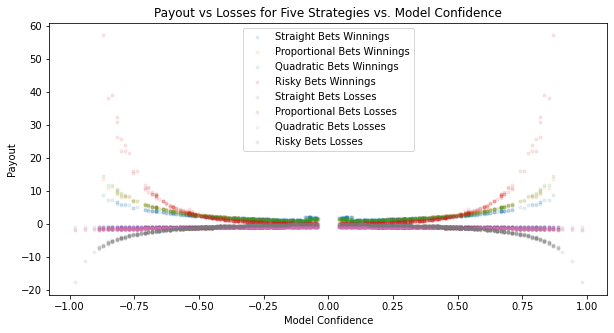

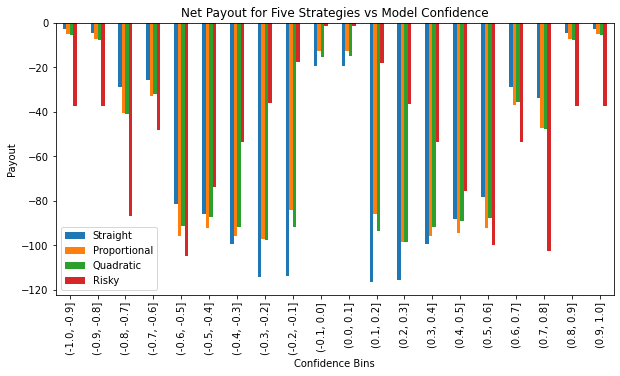

Straight       -1164.782047
Proportional   -1139.929237
Quadratic      -1133.702512
Risky          -1013.024279
dtype: float64
Straight       -0.363994
Proportional   -0.356228
Quadratic      -0.354282
Risky          -0.316570
dtype: float64


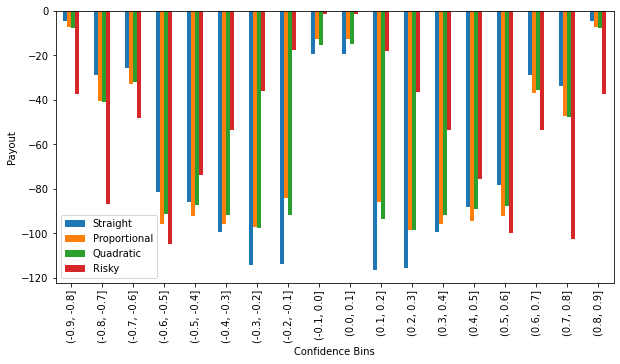

In [435]:
base_odds = odds[['Team Odds','Opponent Odds']].to_numpy(dtype=float)
baseline_preds = implied_probability(base_odds)
plot_bet_strategies(baseline_preds, odds, y_odds)

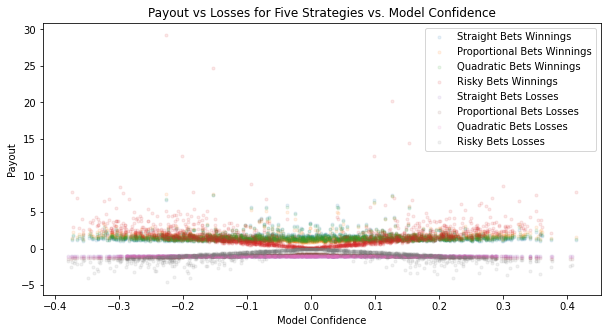

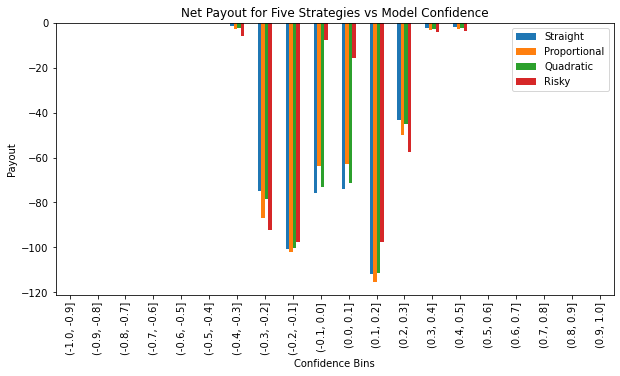

Straight       -486.171937
Proportional   -488.966457
Quadratic      -486.545711
Risky          -382.117081
dtype: float64
Straight       -0.151929
Proportional   -0.152802
Quadratic      -0.152046
Risky          -0.119412
dtype: float64


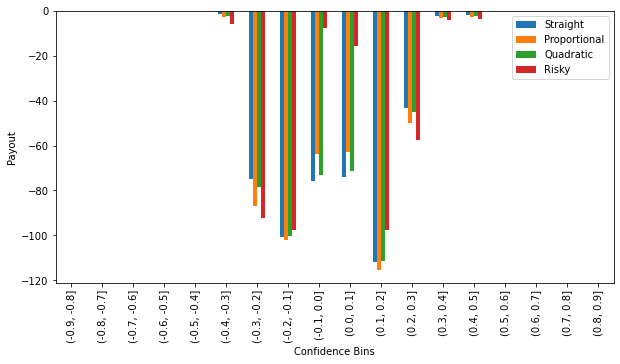

In [436]:
if do_manual_bagging:
    bagging_model.fit(X, y.values.ravel(), baggingclassifier__sample_weight=weights.values.ravel())
    bagging_preds = bagging_model.predict_proba(X_odds)
    plot_bet_strategies(bagging_preds, odds, y_odds)


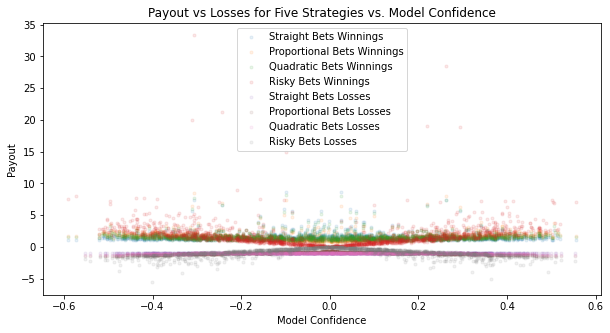

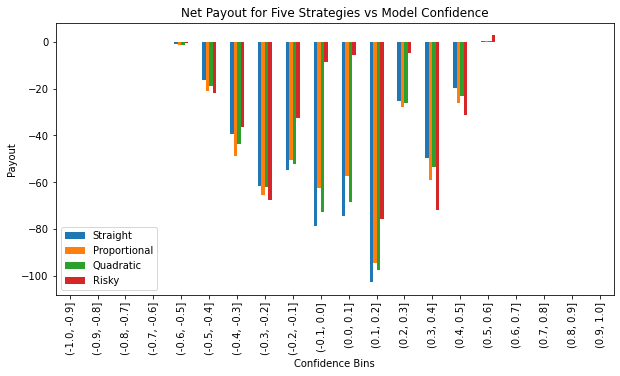

Straight       -523.965797
Proportional   -514.843245
Quadratic      -519.553537
Risky          -354.336363
dtype: float64
Straight       -0.163739
Proportional   -0.160889
Quadratic      -0.162360
Risky          -0.110730
dtype: float64


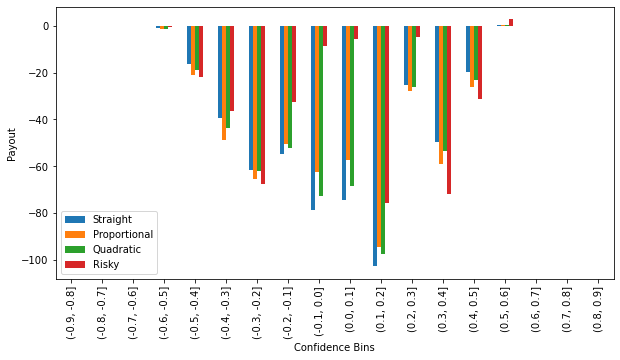

In [423]:

if do_sklearn_grid_tree:
    model = grid_search_bag_tree.best_estimator_
    model.fit(X, y.values.ravel(), bagging_clf__sample_weight=weights.values.ravel())
    grid_preds = model.predict_proba(X_odds)
    plot_bet_strategies(grid_preds, odds, y_odds)


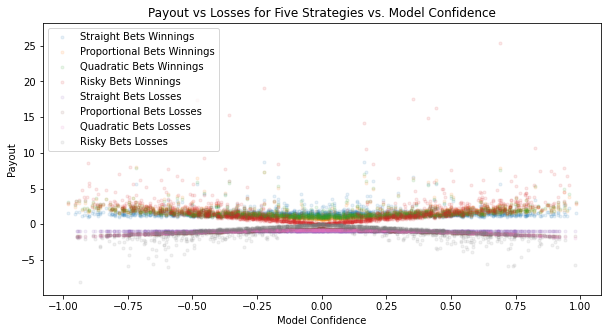

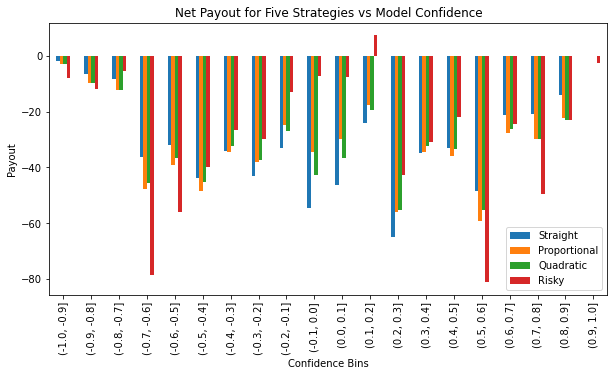

Straight       -601.322612
Proportional   -604.794619
Quadratic      -602.739322
Risky          -552.245350
dtype: float64
Straight       -0.187913
Proportional   -0.188998
Quadratic      -0.188356
Risky          -0.172577
dtype: float64


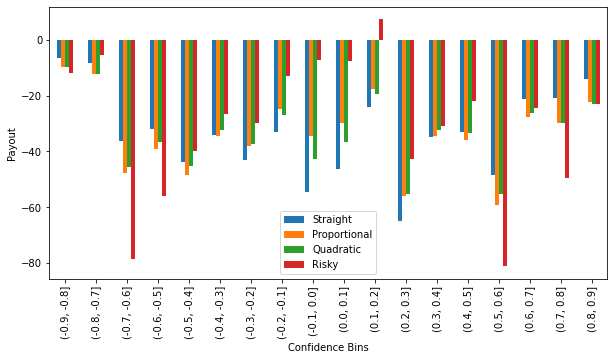

In [424]:

if do_xgboost:
    xgboost_model.fit(X, y.values.ravel(), xgbclassifier__sample_weight=weights.values.ravel())
    xgboost_preds = xgboost_model.predict_proba(X_odds)
    plot_bet_strategies(xgboost_preds, odds, y_odds)


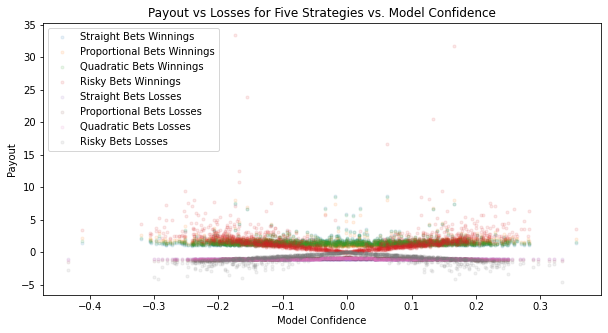

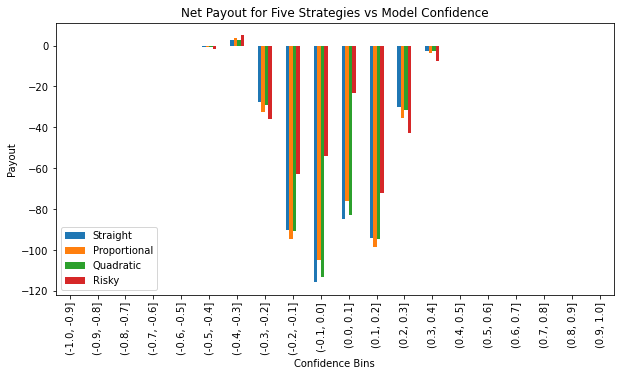

Straight       -443.248329
Proportional   -442.580297
Quadratic      -443.102403
Risky          -294.269099
dtype: float64
Straight       -0.138515
Proportional   -0.138306
Quadratic      -0.138470
Risky          -0.091959
dtype: float64


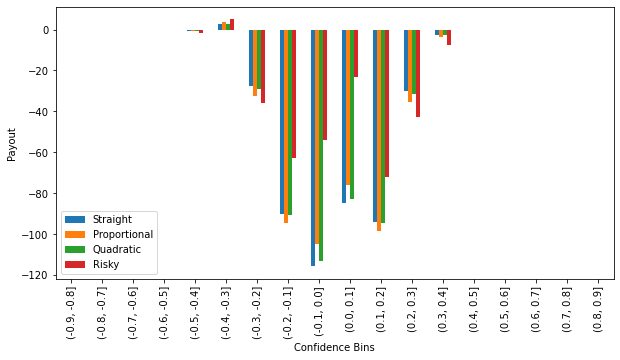

In [425]:

if do_catboost:
    catboost_model.fit(
        X, y,sample_weight=weights,
        cat_features=categorical_columns_indices,
        eval_set=(X_odds, y_odds),
        early_stopping_rounds=100,
        plot=False
    )
    catboost_preds = catboost_model.predict_proba(X_odds)
    plot_bet_strategies(catboost_preds, odds, y_odds)


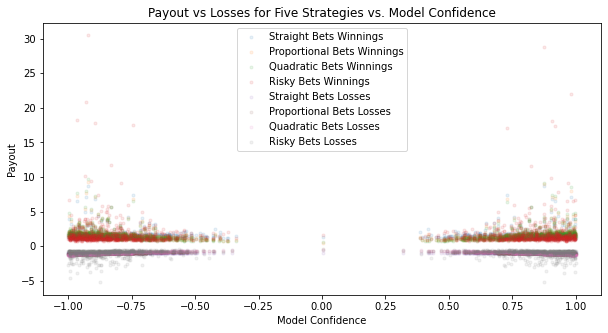

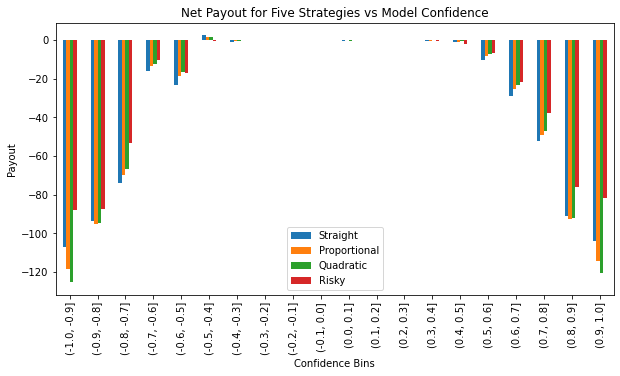

Straight       -601.373357
Proportional   -605.076993
Quadratic      -606.723454
Risky          -483.576652
dtype: float64
Straight       -0.187929
Proportional   -0.189087
Quadratic      -0.189601
Risky          -0.151118
dtype: float64


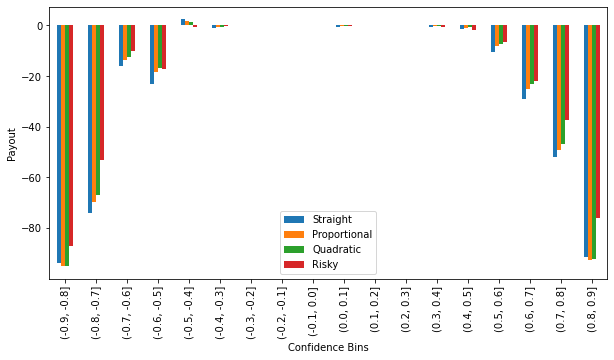

In [426]:
if do_manual_svc:
    linear_model.fit(X, y.values.ravel(),
                     linearsvc__sample_weight=weights.values.ravel())
    linear_preds = linear_model.decision_function(X_odds)
    linear_preds /= (np.max(linear_preds) - np.min(linear_preds))
    linear_preds = np.stack((np.abs(linear_preds * (linear_preds > 0)),
                             np.abs(linear_preds * (linear_preds < 0))), axis=1)
    plot_bet_strategies(linear_preds, odds, y_odds)


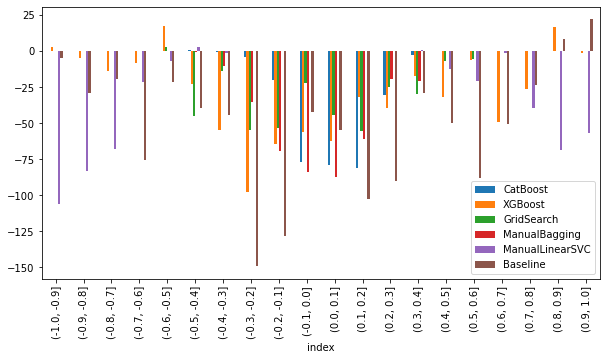

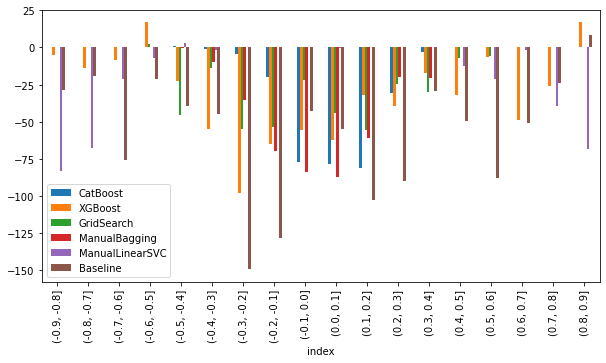

CatBoost           -294.269099
XGBoost            -552.245350
GridSearch         -354.336363
ManualBagging      -387.620143
ManualLinearSVC    -483.576652
Baseline          -1013.024279
dtype: float64


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [427]:
plot_models_across_strategy({'CatBoost':catboost_preds,
                             'XGBoost':xgboost_preds,
                             'GridSearch':grid_preds,
                             'ManualBagging':bagging_preds,
                             'ManualLinearSVC':linear_preds,
                             'Baseline':baseline_preds},
                             odds, y_odds, risky_bet_strategy)

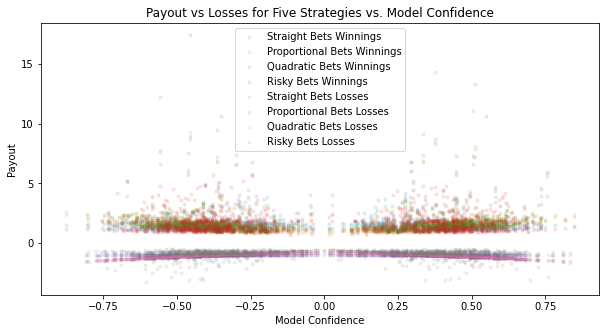

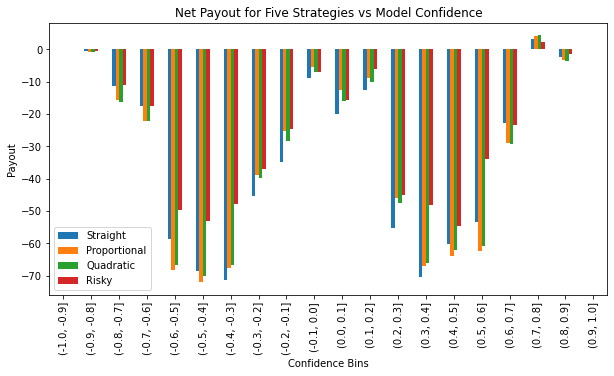

Straight       -611.014960
Proportional   -604.774601
Quadratic      -609.365234
Risky          -475.407441
dtype: float64
Straight       -0.190942
Proportional   -0.188992
Quadratic      -0.190427
Risky          -0.148565
dtype: float64


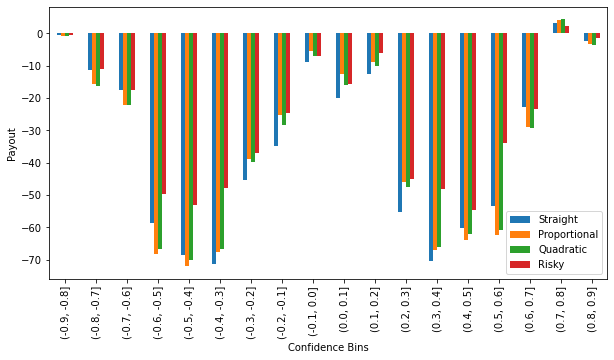

In [428]:
ensemble_preds = catboost_preds * xgboost_preds * grid_preds * bagging_preds * linear_preds
ensemble_preds = np.power(ensemble_preds, 1/5)
plot_bet_strategies(ensemble_preds, odds, y_odds)


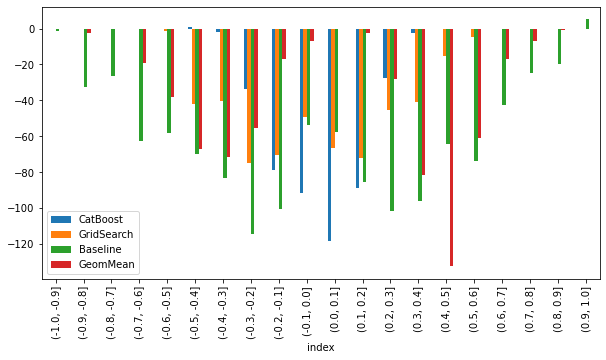

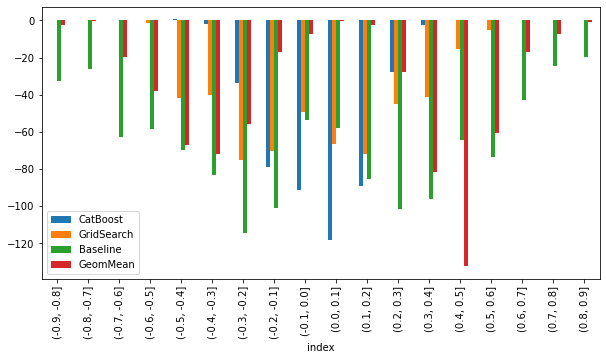

CatBoost      -443.248329
GridSearch    -523.965797
Baseline     -1164.782047
GeomMean      -611.014960
dtype: float64


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [429]:
plot_models_across_strategy({'CatBoost':catboost_preds,
                             'GridSearch':grid_preds,
                             'Baseline':baseline_preds,
                             'GeomMean':ensemble_preds},
                             odds, y_odds, straight_bet_strategy)

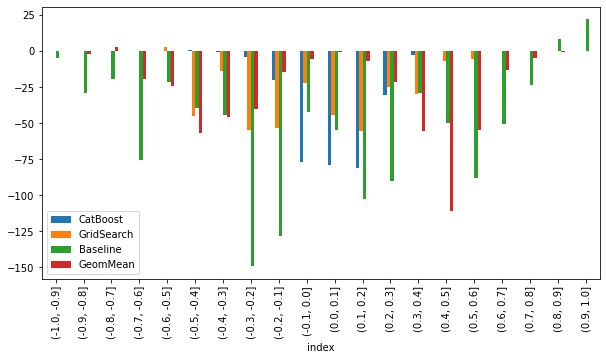

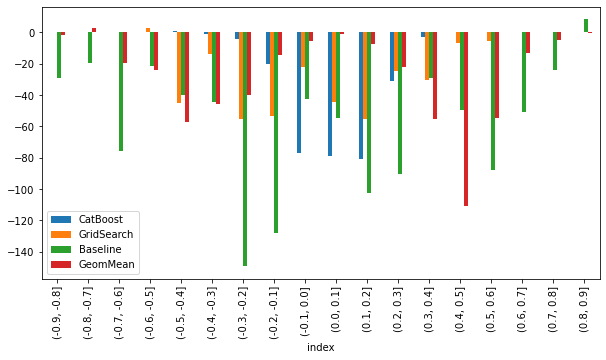

CatBoost      -294.269099
GridSearch    -354.336363
Baseline     -1013.024279
GeomMean      -475.407441
dtype: float64


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [437]:
plot_models_across_strategy({'CatBoost':catboost_preds,
                             'GridSearch':grid_preds,
                             'Baseline':baseline_preds,
                             'GeomMean':ensemble_preds},
                             odds, y_odds, risky_bet_strategy)

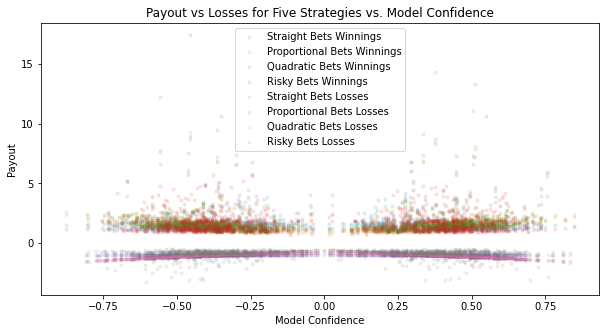

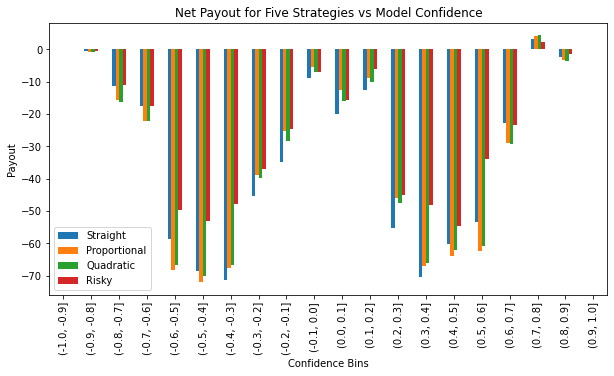

Straight       -611.014960
Proportional   -604.774601
Quadratic      -609.365234
Risky          -475.407441
dtype: float64
Straight       -0.190942
Proportional   -0.188992
Quadratic      -0.190427
Risky          -0.148565
dtype: float64


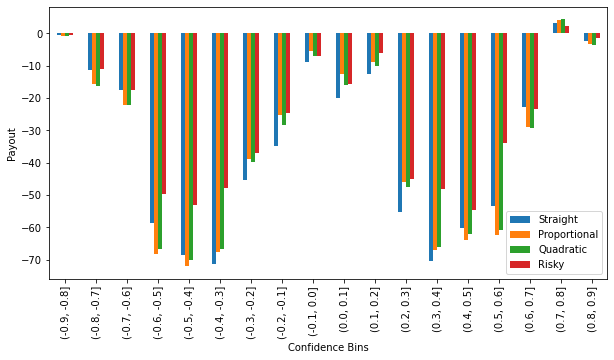

In [438]:
plot_bet_strategies(ensemble_preds, odds, y_odds)